# Tutorial Part 19: Screening Zinc For HIV Inhibition

In this tutorial we will walk through how to efficiently screen a large compound library with DeepChem (ZINC).  Screening a large compound library using machine learning is a CPU bound pleasingly parrellel problem.  The actual code examples I will use assume the resources available are a single very big machine (like an AWS c5.18xlarge), but should be readily swappable for other systmes (like a super computing cluster).  At a high level what we will do is...

1. Create a Machine Learning Model Over Labeled Data
2. Transform ZINC into "Work-Units"
3. Create an inference script which runs predictions over a "Work-Unit"
4. Load "Work-Unit" into a "Work Queue"
5. Consume work units from "Work Queue"
6. Gather Results

This tutorial is unlike the previous tutorials in that it's designed to be run on AWS rather than on Google Colab. That's because we'll need access to a large machine with many cores to do this computation efficiently. We'll try to provide details about how to do this throughout the tutorial.

# 1. Train Model On Labelled Data

We are just going to knock out a simple model here.  In a real world problem you will probably try several models and do a little hyper parameter searching.

In [1]:
from deepchem.molnet.load_function import hiv_datasets

/Users/bharath/opt/anaconda3/envs/deepchem/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
RDKit WARNING: [18:15:24] Enabling RDKit 2019.09.3 jupyter extensions
/Users/bharath/opt/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/bharath/opt/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Pas

In [2]:
from deepchem.models import GraphConvModel
from deepchem.data import NumpyDataset
from sklearn.metrics import average_precision_score
import numpy as np

tasks, all_datasets, transformers = hiv_datasets.load_hiv(featurizer="GraphConv")
train, valid, test = [NumpyDataset.from_DiskDataset(x) for x in all_datasets]
model = GraphConvModel(1, mode="classification")
model.fit(train)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /var/folders/st/ds45jcqj2232lvhr0y9qt5sc0000gn/T/HIV.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 12.479 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 1 took 13.668 s
Loading shard 3 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 2 took 13.550 s
Loading shard 

RDKit WARNING: [18:16:53] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:16:53] WARNING: not removing hydrogen atom without neighbors


Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 4 took 13.362 s
Loading shard 6 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 5 took 0.355 s
TIMING: dataset construction took 80.394 s
Loading dataset from disk.
TIMING: dataset construction took 16.676 s
Loading dataset from disk.
TIMING: dataset construction took 7.529 s
Loading dataset from disk.
TIMING: dataset construction took 7.796 s
Loading dataset from disk.
TIMING: dataset construction took 17.521 s
Loading dataset from disk.
TIMING: dataset construction took 7.770 s
Loading dataset from disk.
TIMING: dataset construction took 7.873 s
Loading dataset from disk.
TIMING: dataset construction took 15.495 s
Loading dataset from disk.
TIMING: dataset construction took 1.959 s
Loading dataset from disk.
TIMING: dataset construction took 1.949 s
Loading dataset from disk.
Instructions for updating:
C




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/Users/bharath/opt/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/bharath/opt/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/bharath/opt/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.0

In [3]:
y_true = np.squeeze(valid.y)
y_pred = model.predict(valid)[:,0,1]
print("Average Precision Score:%s" % average_precision_score(y_true, y_pred))
sorted_results = sorted(zip(y_pred, y_true), reverse=True)
hit_rate_100 = sum(x[1] for x in sorted_results[:100]) / 100
print("Hit Rate Top 100: %s" % hit_rate_100)

Average Precision Score:0.19783388433313015
Hit Rate Top 100: 0.37


## Retrain Model Over Full Dataset For The Screen

In [29]:
tasks, all_datasets, transformers = hiv_datasets.load_hiv(featurizer="GraphConv", split=None)

model = GraphConvModel(1, mode="classification", model_dir="/tmp/zinc/screen_model")
model.fit(all_datasets[0])

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/HIV.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 15.701 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 1 took 15.869 s
Loading shard 3 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 2 took 19.106 s
Loading shard 4 of size 8192.
Featurizing sample 0
Featuri

/home/leswing/miniconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# 2. Create Work-Units

1. Download All of ZINC15.

Go to http://zinc15.docking.org/tranches/home and download all non-empty tranches in .smi format.
I found it easiest to download the wget script and then run the wget script.
For the rest of this tutorial I will assume zinc was downloaded to /tmp/zinc.


The way zinc downloads the data isn't great for inference.  We want "Work-Units" which a single CPU can execute that takes a resonable amount of time (10 minutes to an hour).  To accomplish this we are going to split the zinc data into files each with 500 thousand lines.


```bash
mkdir /tmp/zinc/screen
find /tmp/zinc -name '*.smi' -exec cat {} \; | grep -iv "smiles" \
     | split -l 500000 /tmp/zinc/screen/segment
```

This bash command
1. Finds all smi files
2. prints to stdout the contents of the file
3. removes header lines
4. splits into multiple files in /tmp/zinc/screen that are 500k molecules long

## 3. Creat Inference Script

Now that we have work unit we need to construct a program which ingests a work unit and logs the result.  It is important that the logging mechanism is thread safe!
For this example we will get the work unit via a file-path, and log the result to a file.
An easy extensions to distribute over multiple computers would be to get the work unit via a url, and log the results to a distributed queue.

Here is what mine looks like

inference.py
```python
import sys
import deepchem as dc
import numpy as np
from rdkit import Chem
import pickle
import os


def create_dataset(fname, batch_size=50000):
    featurizer = dc.feat.ConvMolFeaturizer()
    fin = open(fname)
    mols, orig_lines = [], []
    for line in fin:
        line = line.strip().split()
        try:
            mol = Chem.MolFromSmiles(line[0])
            if mol is None:
                continue
            mols.append(mol)
            orig_lines.append(line)
        except:
            pass
        if len(mols) > 0 and len(mols) % batch_size == 0:
            features = featurizer.featurize(mols)
            y = np.ones(shape=(len(mols), 1))
            ds = dc.data.NumpyDataset(features, y)
            yield ds, orig_lines
            mols, orig_lines = [], []
    if len(mols) > 0:
        features = featurizer.featurize(mols)
        y = np.ones(shape=(len(mols), 1))
        ds = dc.data.NumpyDataset(features, y)
        yield ds, orig_lines


def evaluate(fname):
    fout_name = "%s_out.smi" % fname
    model = dc.models.TensorGraph.load_from_dir('screen_model')
    for ds, lines in create_dataset(fname):
        y_pred = np.squeeze(model.predict(ds), axis=1)
        with open(fout_name, 'a') as fout:
            for index, line in enumerate(lines):
                line.append(y_pred[index][1])
                line = [str(x) for x in line]
                line = "\t".join(line)
                fout.write("%s\n" % line)


if __name__ == "__main__":
    evaluate(sys.argv[1])
```

# 4. Load "Work-Unit" into a "Work Queue"

We are going to use a flat file as our distribution mechanism.  It will be a bash script calling our inference script for every work unit.  If you are at an academic institution this would be queing your jobs in pbs/qsub/slurm.  An option for cloud computing would be rabbitmq or kafka.

In [ ]:
import os
work_units = os.listdir('/tmp/zinc/screen')
with open('/tmp/zinc/work_queue.sh', 'w') as fout:
    fout.write("#!/bin/bash\n")
    for work_unit in work_units:
        full_path = os.path.join('/tmp/zinc', work_unit)
        fout.write("python inference.py %s" % full_path)

# 5. Consume work units from "distribution mechanism"

We will consume work units from our work queue using a very simple Process Pool.  It takes lines from our "Work Queue" and runs them, running as many processes in parrallel as we have cpus.  If  you are using a supercomputing cluster system like pbs/qsub/slurm it will take care of this for you.  The key is to use one CPU per work unit to get highest throughput.  We accomplish that here using the linux utility "taskset".

Using an c5.18xlarge on aws this will finish overnight. 

process_pool.py
```python
import multiprocessing
import sys
from multiprocessing.pool import Pool

import delegator


def run_command(args):
  q, command = args
  cpu_id = q.get()
  try:
    command = "taskset -c %s %s" % (cpu_id, command)
    print("running %s" % command)
    c = delegator.run(command)
    print(c.err)
    print(c.out)
  except Exception as e:
    print(e)
  q.put(cpu_id)


def main(n_processors, command_file):
  commands = [x.strip() for x in open(command_file).readlines()]
  commands = list(filter(lambda x: not x.startswith("#"), commands))
  q = multiprocessing.Manager().Queue()
  for i in range(n_processors):
    q.put(i)
  argslist = [(q, x) for x in commands]
  pool = Pool(processes=n_processors)
  pool.map(run_command, argslist)


if __name__ == "__main__":
  processors = multiprocessing.cpu_count()
  main(processors, sys.argv[1])
```


```bash
>> python process_pool.py /tmp/zinc/work_queue.sh
```

# 6. Gather Results
Since we logged our results to \*_out.smi we now need to gather all of them up and sort them by our predictions.  The resulting file wile be > 40GB.  To analyze the data further you can use dask, or put the data in a rdkit postgres cartridge.

Here I show how to join the and sort the data to get the "best" results.

```bash
find /tmp/zinc -name '*_out.smi' -exec cat {} \; > /tmp/zinc/screen/results.smi
sort -rg -k 3,3 /tmp/zinc/screen/results.smi > /tmp/zinc/screen/sorted_results.smi
# Put the top 100k scoring molecules in their own file
head -n 50000 /tmp/zinc/screen/sorted_results.smi > /tmp/zinc/screen/top_100k.smi
```

/tmp/zinc/screen/top_100k.smi is now a small enough file to investigate using standard tools like pandas.

In [9]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D 
best_mols = [Chem.MolFromSmiles(x.strip().split()[0]) for x in open('/tmp/zinc/screen/top_100k.smi').readlines()[:100]]
best_scores = [x.strip().split()[2] for x in open('/tmp/zinc/screen/top_100k.smi').readlines()[:100]]

0.98874843


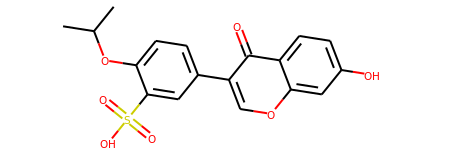

In [10]:
print(best_scores[0])
best_mols[0]

0.98874843


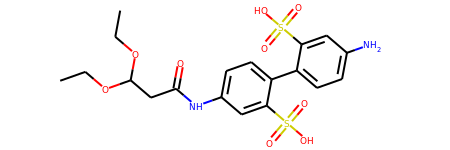

In [11]:
print(best_scores[0])
best_mols[1]

0.98874843


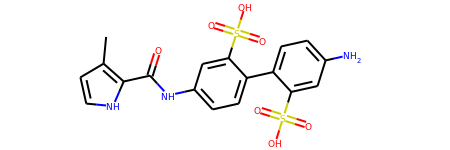

In [12]:
print(best_scores[0])
best_mols[2]

0.98874843


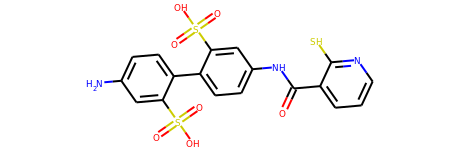

In [13]:
print(best_scores[0])
best_mols[3]

The screen seems to favor molecules with one or multiple sulfur trioxides. The top scoring molecules also have low diversity.  When creating a "buy list" we want to optimize for more things than just activity, for instance diversity and drug like MPO. 

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!